# Angular format data

## Build vanilla RAG system

In [1]:
from langchain_community.document_loaders import JSONLoader
from tqdm.auto import tqdm
import json
import pickle
from langchain.text_splitter import Language
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
import glob
import os
from collections import defaultdict

In [2]:
# Define the path to the pre-trained model you want to use
# modelPath = "mixedbread-ai/mxbai-embed-large-v1"
# modelPath = "mchochlov/codebert-base-cd-ft"
# modelPath= "microsoft/unixcoder-base"
# modelPath ="codecompletedeployment/st-codesearch-distilroberta-base"
modelPath = "intfloat/e5-small-v2"
# modelPath = "sentence-transformers/all-MiniLM-L6-v2"
# modelPath = "../models/models-e5-v2-finetuned-10w-epoch20"

# for modelPath in ["mixedbread-ai/mxbai-embed-large-v1", "intfloat/e5-small-v2", "sentence-transformers/all-MiniLM-L6-v2"]:
model_kwargs = {'device':'cuda', 'trust_remote_code': True}

# Create a dictionary with encoding options, specifically setting 'normalize_embeddings' to False
encode_kwargs = {'normalize_embeddings': True}

# Initialize an instance of HuggingFaceEmbeddings with the specified parameters
embeddings = HuggingFaceEmbeddings(
    cache_folder = '../models',
    model_name=modelPath,     # Provide the pre-trained model's path
    model_kwargs=model_kwargs, # Pass the model configuration options
    encode_kwargs=encode_kwargs # Pass the encoding options
)

In [3]:
diff_loader = JSONLoader(
    file_path='../data/angular_filtered/subsets/db_data.json',
    jq_schema='.[].diff',
    text_content=False)

diff_data = diff_loader.load()

msg_loader = JSONLoader(
    file_path='../data/angular_filtered/subsets/db_data.json',
    jq_schema='.[].msg',
    text_content=False)

msg_data = msg_loader.load()

In [4]:
test_diff_loader = JSONLoader(
    file_path='../data/angular_filtered/subsets/dev_test.json',
    jq_schema='.[].diff',
    text_content=False)

test_diff_data = test_diff_loader.load()
# test_diff_data = test_diff_loader.load()[:1000]

with open('../data/angular_filtered/subsets/dev_test.json', 'r', encoding='UTF-8') as f:
    test_data = json.load(f)

## Different chunking size

In [9]:
def similarity_search(documents, db):
    # Initialize an empty dictionary to store aggregate scores for each candidate ID
    aggregate_scores = {}

    # Iterate through each document in the documents list
    for document in documents:
        # Apply similarity search function to the document
        results = db.similarity_search_with_relevance_scores(document.page_content, score_threshold=0.0)
        # Iterate through the results for each document
        for candidate_doc in results:
            id = candidate_doc[0].metadata['seq_num']
            score = candidate_doc[1]
            # Update the aggregate score for the candidate ID
            aggregate_scores[id] = aggregate_scores.get(id, 0) + score

    # Find the candidate ID with the highest aggregate score
    if aggregate_scores:
        max_candidate_id = max(aggregate_scores, key=aggregate_scores.get)
    else:
        max_candidate_id = -1

    return max_candidate_id

In [10]:
for size in [500, 1000, 2500]:
    splitter = RecursiveCharacterTextSplitter.from_language(Language.JS, chunk_size=size, chunk_overlap=(size/5))
    
    diff_split = []
    
    for i, doc in tqdm(enumerate(diff_data), total=len(diff_data), desc="Processing documents"):
        diff_split += splitter.split_documents([doc])
    
    db = Chroma.from_documents(diff_split, embeddings, persist_directory=f"../data/angular_filtered/subsets/type_db/rag_all_types_db_e5_{size}chunk")
    similar_diff_id = []
    for diff_doc in tqdm(test_diff_data, total=len(test_diff_data), desc="Processing documents"):
        documents = splitter.split_documents([diff_doc])
        similar_diff_id.append(similarity_search(documents, db))
    

    for sim_diff_id, test_diff in zip(similar_diff_id, test_data):
        test_diff['sim_msg'] = msg_data[sim_diff_id-1].page_content
        test_diff['sim_diff'] = diff_data[sim_diff_id-1].page_content
    
    with open(f'../data/angular_filtered/subsets/generation/rag/dev_test_rag_prompt_{size}chunk.json', 'w', encoding='UTF-8') as f:
        json.dump(test_data, f, ensure_ascii=False, indent=4)

Processing documents:   0%|          | 0/53855 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/501 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/53855 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/501 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/53855 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/501 [00:00<?, ?it/s]

In [15]:
from openai import OpenAI

client = OpenAI(
    api_key="sk-0rLvuRkMiD4Mw25QYygh6rUlZVjpQWNGNF4yez7z3PZ7yCOm",
    base_url="https://api.chatanywhere.cn/v1"
)

def gpt_35_api(messages: list):

    completion = client.chat.completions.create(model="gpt-3.5-turbo-0125", messages=messages, temperature=0)
    return completion.choices[0].message.content

import json
from tqdm import tqdm
from langchain import hub
prompt = hub.pull("tyfann/llm4commit-rag:b843ef0b")

for size in [500, 1000, 2500, 'no']:
    with open(f'../data/angular_filtered/subsets/generation/rag/dev_test_rag_prompt_{size}chunk.json', 'r', encoding='UTF-8') as f:
        org_data = json.load(f)
    gpt_msg = []
    for index, data in tqdm(enumerate(org_data), total=len(org_data), desc="Processing documents"):
        messages = prompt.invoke(
            {"context": data['sim_diff'], "msg": data['sim_msg'], "diff": data['diff']}
        ).to_messages()
        example_prompt = [{'role': 'user','content': messages[0].content},]
        try:
            gpt_msg.append(gpt_35_api(example_prompt))
        except:
            print(index)
            gpt_msg.append('')

    for item, msg in zip(org_data, gpt_msg):
        item['chatgpt_rag'] = msg

    output_file = f'../data/angular_filtered/subsets/generation/test_gpt35_rag_{size}chunk.json'
    with open(output_file, 'w', encoding='UTF-8') as f:
        json.dump(org_data, f, ensure_ascii=False, indent=4)
        
    output_file = f'../data/angular_filtered/subsets/generation/test_gpt35_rag_{size}chunk.txt'
    with open(output_file, 'w', encoding='UTF-8') as f:
        for item in org_data:
            f.write(item['chatgpt_rag'].replace('\n', '\\n').replace('\r', '\\r') + '\n')

Processing documents: 100%|██████████| 501/501 [07:16<00:00,  1.15it/s]


In [17]:
output_file = f'../data/angular_filtered/subsets/generation/chunksize/dev_test_ref.txt'
with open(output_file, 'w', encoding='UTF-8') as f:
    for item in org_data:
        f.write(item['msg'].replace('\n', '\\n').replace('\r', '\\r') + '\n')

In [5]:
if os.path.exists(f"../data/angular_filtered/subsets/type_db/rag_all_types_db_miniLM_nochunk"):
    db = Chroma(persist_directory=f"../data/angular_filtered/subsets/type_db/rag_all_types_db_miniLM_nochunk", embedding_function=embeddings)
else:
    db = Chroma.from_documents(diff_data, embeddings, persist_directory="../data/angular_filtered/subsets/type_db/rag_all_types_db_miniLM_nochunk")

In [5]:
test_diff_loader = JSONLoader(
    file_path='../data/angular_filtered/subsets/dev_test.json',
    jq_schema='.[].diff',
    text_content=False)

test_diff_data = test_diff_loader.load()
# test_diff_data = test_diff_loader.load()[:1000]

with open('../data/angular_filtered/subsets/dev_test.json', 'r', encoding='UTF-8') as f:
    test_data = json.load(f)

In [6]:
similar_diff = []
retriever = db.as_retriever()
for diff_doc in tqdm(test_diff_data, total=len(test_diff_data), desc="Processing documents"):
    similar_diff.append(retriever.invoke(diff_doc.page_content)[0])

for sim_diff, test_item in zip(similar_diff, test_data):
    test_item['sim_msg'] = msg_data[sim_diff.metadata['seq_num']-1].page_content
    test_item['sim_diff'] = diff_data[sim_diff.metadata['seq_num']-1].page_content

with open('../data/angular_filtered/subsets/generation/embedding/dev_test_rag_prompt_miniLM.json', 'w', encoding='UTF-8') as f:
    json.dump(test_data, f, ensure_ascii=False, indent=4)

Processing documents:   0%|          | 0/501 [00:00<?, ?it/s]

In [7]:
from openai import OpenAI

client = OpenAI(
    api_key="sk-0rLvuRkMiD4Mw25QYygh6rUlZVjpQWNGNF4yez7z3PZ7yCOm",
    base_url="https://api.chatanywhere.cn/v1"
)

def gpt_35_api(messages: list):

    completion = client.chat.completions.create(model="gpt-3.5-turbo-0125", messages=messages, temperature=0)
    return completion.choices[0].message.content

import json
from tqdm import tqdm
from langchain import hub
prompt = hub.pull("tyfann/llm4commit-rag:b843ef0b")

for model in ['mxbai', 'miniLM']:
    with open(f'../data/angular_filtered/subsets/generation/embedding/dev_test_rag_prompt_{model}.json', 'r', encoding='UTF-8') as f:
        org_data = json.load(f)
    gpt_msg = []
    for index, data in tqdm(enumerate(org_data), total=len(org_data), desc="Processing documents"):
        messages = prompt.invoke(
            {"context": data['sim_diff'], "msg": data['sim_msg'], "diff": data['diff']}
        ).to_messages()
        example_prompt = [{'role': 'user','content': messages[0].content},]
        try:
            gpt_msg.append(gpt_35_api(example_prompt))
        except:
            print(index)
            gpt_msg.append('')

    for item, msg in zip(org_data, gpt_msg):
        item['chatgpt_rag'] = msg

    output_file = f'../data/angular_filtered/subsets/generation/embedding/dev_test_gpt35_rag_{model}.json'
    with open(output_file, 'w', encoding='UTF-8') as f:
        json.dump(org_data, f, ensure_ascii=False, indent=4)
        
    output_file = f'../data/angular_filtered/subsets/generation/embedding/dev_test_gpt35_rag_{model}.txt'
    with open(output_file, 'w', encoding='UTF-8') as f:
        for item in org_data:
            f.write(item['chatgpt_rag'].replace('\n', '\\n').replace('\r', '\\r') + '\n')

Processing documents: 100%|██████████| 501/501 [06:59<00:00,  1.19it/s]


In [13]:
from openai import OpenAI

client = OpenAI(
    api_key="sk-0rLvuRkMiD4Mw25QYygh6rUlZVjpQWNGNF4yez7z3PZ7yCOm",
    base_url="https://api.chatanywhere.cn/v1"
)

def gpt_35_api(messages: list):

    completion = client.chat.completions.create(model="gpt-3.5-turbo-0125", messages=messages, temperature=0)
    return completion.choices[0].message.content

import json
from tqdm import tqdm
from langchain import hub
prompt = hub.pull("tyfann/llm4commit-rag:b843ef0b")


In [14]:
with open(f'../data/angular_filtered/subsets/generation/rag/test_rag_prompt.json', 'r', encoding='UTF-8') as f:
    org_data = json.load(f)
gpt_msg = []
for index, data in tqdm(enumerate(org_data), total=len(org_data), desc="Processing documents"):
    # merged_diff = '\n'.join(diff['diff'] for diff in data['diff'])
    messages = prompt.invoke(
        {"context": data['sim_diff'], "msg": data['sim_msg'], "diff": data['diff']}
    ).to_messages()
    example_prompt = [{'role': 'user','content': messages[0].content},]
    try:
        gpt_msg.append(gpt_35_api(example_prompt))
    except:
        print(index)
        gpt_msg.append('')
    # gpt_msg.append(gpt_35_api(example_prompt))

for item, msg in zip(org_data, gpt_msg):
    item['chatgpt_rag'] = msg

output_file = f'../data/angular_filtered/subsets/generation/test_gpt35_rag.json'
with open(output_file, 'w', encoding='UTF-8') as f:
    json.dump(org_data, f, ensure_ascii=False, indent=4)
    
output_file = f'../data/angular_filtered/subsets/generation/test_gpt35_rag.txt'
with open(output_file, 'w', encoding='UTF-8') as f:
    for item in org_data:
        f.write(item['chatgpt_rag'].replace('\n', '\\n').replace('\r', '\\r') + '\n')

Processing documents:   0%|          | 0/501 [00:00<?, ?it/s]


KeyError: "Input to ChatPromptTemplate is missing variables {'diff'}.  Expected: ['context', 'diff', 'msg'] Received: ['context', 'msg']"

## Build classified RAG system

In [7]:
types = [
    'build', 'ci', 'docs', 'feat', 'fix', 
    'perf', 'refactor', 'style', 'test', 'chore'
]
type_label_mapping = {type_name: idx for idx, type_name in enumerate(types)}
output_dir = '../data/angular_filtered/subsets/classification'
# Save the type-label mapping to a txt file
with open(os.path.join(output_dir, 'type_label_mapping.txt'), 'w') as mapping_file:
    for type_name, label in type_label_mapping.items():
        mapping_file.write(f'{type_name}: {label}\n')

In [8]:
def read_mapping(file_path):
    mapping = {}
    with open(file_path, 'r') as f:
        for line in f:
            key, value = line.strip().split(': ')
            mapping[key] = int(value)
    return mapping

# 读取json文件
def read_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# 写入jsonl文件
def write_jsonl(file_path, data):
    with open(file_path, 'w') as f:
        for item in data:
            json.dump(item, f)
            f.write('\n')

# 主函数
def main(mapping_file, json_file, output_file):
    # 读取mapping和json数据
    mapping = read_mapping(mapping_file)
    json_data = read_json(json_file)
    # random.seed(42)
    # random.shuffle(json_data)

    # 生成新的jsonl数据
    new_data = []
    for item in json_data:
        new_item = {
            "code": item["diff"],
            "label": mapping[item["type"]]
        }
        new_data.append(new_item)

    # 写入新的jsonl文件
    write_jsonl(output_file, new_data)

# 调用主函数
mapping_file = '../data/angular_filtered/subsets/classification/type_label_mapping.txt'
json_file = '../data/angular_filtered/subsets/test_data.json'
output_file = '../../CodeBERT-classification/dataset/test_angular.jsonl'
main(mapping_file, json_file, output_file)

In [9]:
import json
import glob
import os
from sklearn.model_selection import train_test_split
import random
random.seed(42)

# Define the directory containing the JSON files
output_dir = '../../CodeBERT-classification/dataset'

# List of types and their corresponding labels
types = [
    'build', 'ci', 'docs', 'feat', 'fix', 
    'perf', 'refactor', 'style', 'test', 'chore'
]
type_label_mapping = {type_name: idx for idx, type_name in enumerate(types)}

train_items = []
valid_items = []

# Read and process all test JSON files
for type_name in types:
    test_file = os.path.join('../data/angular_filtered/subsets/type_db', f'JavaScript_{type_name}_db.json')
    if os.path.exists(test_file):
        with open(test_file, 'r') as f:
            items = json.load(f)
            data = [
                {
                    "code": item['diff'],
                    "label": type_label_mapping[type_name]
                }
                for item in items
            ]
            # Split data into 1:8 ratio
            train_split, valid_split = train_test_split(data, test_size=1/10, random_state=42)
            valid_items.extend(valid_split)
            train_items.extend(train_split)

# Shuffle the items to randomize their order
random.shuffle(valid_items)
random.shuffle(train_items)

# Save validation items to valid.jsonl
with open(os.path.join(output_dir, 'valid_angular.jsonl'), 'w') as valid_file:
    for item in valid_items:
        valid_file.write(json.dumps(item) + '\n')

# Save training items to train.jsonl
with open(os.path.join(output_dir, 'train_angular.jsonl'), 'w') as train_file:
    for item in train_items:
        train_file.write(json.dumps(item) + '\n')

print("Data splitting and saving to JSONL files completed.")


Data splitting and saving to JSONL files completed.


calculate vanilla rag accuracy

In [12]:
import re
import json
def get_commit_type(msg, has_space=True):
    types = '((build)|(ci)|(docs)|(feat)|(fix)|(perf)|(refactor)|(style)|(test)|(chore))'
    if has_space:
        pattern = f'^{types}\\s(\\((\\s|\\S)+\\))?:\\s*(\\s|\\S)+'
    else:
        pattern = f'^{types}(\\((\\s|\\S)+\\))?:\\s*\\S+(\\s|\\S)+'
    match = re.match(pattern, msg)
    if match:
        return match.group(1)
    return None

with open('../data/angular_filtered/subsets/generation/rag/test_rag_prompt.json', 'r', encoding='UTF-8') as f:
    prompt = json.load(f)

count = 0
for item in prompt:
    sim_type = get_commit_type(item['sim_msg'])
    if sim_type is not None:
        if sim_type == item['type']:
            count +=1
    else:
        sim_type = get_commit_type(item['sim_msg'], False)
        if sim_type is not None:
            if sim_type == item['type']:
                count +=1
        else:
            print('fail')

print(count / len(prompt) * 100 , "%")

26.967418546365913 %


In [10]:
import re
import json
def get_commit_type(msg, has_space=True):
    types = '((build)|(ci)|(docs)|(feat)|(fix)|(perf)|(refactor)|(style)|(test)|(chore))'
    if has_space:
        pattern = f'^{types}\\s(\\((\\s|\\S)+\\))?:\\s*(\\s|\\S)+'
    else:
        pattern = f'^{types}(\\((\\s|\\S)+\\))?:\\s*\\S+(\\s|\\S)+'
    match = re.match(pattern, msg)
    if match:
        return match.group(1)
    return None

with open('../data/angular_filtered/subsets/generation/rag/test_rag_prompt.json', 'r', encoding='UTF-8') as f:
    prompt = json.load(f)

count = 0
pred_type = []
for item in prompt:
    sim_type = get_commit_type(item['sim_msg'])
    if sim_type is not None:
        pred_type.append(sim_type)
    else:
        sim_type = get_commit_type(item['sim_msg'], False)
        if sim_type is not None:
            pred_type.append(sim_type)
        else:
            print('fail')

In [15]:
ref_type = [item['type'] for item in prompt]

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def read_mapping(file_path):
    mapping = {}
    with open(file_path, 'r', encoding='UTF-8') as f:
        for line in f:
            key, value = line.strip().split(': ')
            mapping[key] = int(value)  # 将value转换为int作为键，key作为值
    return mapping

mapping_file = '../data/angular_filtered/subsets/classification/type_label_mapping.txt'
mapping = read_mapping(mapping_file)


In [30]:
pref_mapping = []
for item in pred_type:
    pref_mapping.append(mapping[item])

# to a txt file
with open('../data/angular_filtered/subsets/classification/angular_test_rag_predictions.txt', 'w') as f:
    for item in pref_mapping:
        f.write(f'{item}\n')

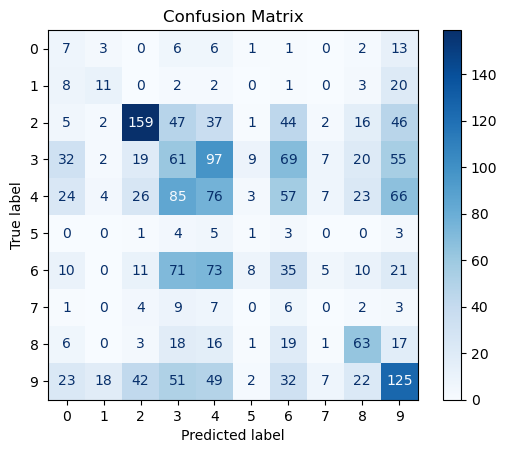

In [31]:

# 读取标签文件
def read_labels(file_path):
    with open(file_path, 'r') as f:
        labels = [int(line.strip()) for line in f]
    return labels

# 主函数
def main(ref_file, pred_file):
    # 读取ref和pred标签
    y_true = read_labels(ref_file)
    y_pred = read_labels(pred_file)

    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(10))
    
    # 绘制混淆矩阵
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# 调用主函数
ref_file = '../data/angular_filtered/subsets/classification/angular_test_references.txt'
pred_file = '../data/angular_filtered/subsets/classification/angular_test_rag_predictions.txt'
main(ref_file, pred_file)

classification result to json

In [4]:
import json

# 读取mapping.txt文件
def read_mapping(file_path):
    mapping = {}
    with open(file_path, 'r', encoding='UTF-8') as f:
        for line in f:
            key, value = line.strip().split(': ')
            mapping[int(value)] = key  # 将value转换为int作为键，key作为值
    return mapping

# 读取json文件
def read_json(file_path):
    with open(file_path, 'r', encoding='UTF-8') as f:
        data = json.load(f)
    return data

# 读取pred.txt文件
def read_labels(file_path):
    with open(file_path, 'r', encoding='UTF-8') as f:
        labels = [int(line.strip()) for line in f]
    return labels

# 写入json文件
def write_json(file_path, data):
    with open(file_path, 'w', encoding='UTF-8') as f:
        json.dump(data, f, indent=4)

# 主函数
def main(mapping_file, json_file, pred_file, output_file):
    # 读取mapping和json数据
    mapping = read_mapping(mapping_file)
    json_data = read_json(json_file)
    pred_labels = read_labels(pred_file)

    # 添加classifier_type字段
    for item, label in zip(json_data, pred_labels):
        item["classifier_type"] = mapping[label]

    # 写入更新后的json文件
    write_json(output_file, json_data)

# 调用主函数
mapping_file = '../data/angular_filtered/subsets/classification/type_label_mapping.txt'
json_file = '../data/angular_filtered/subsets/test_data.json'
pred_file = '../data/angular_filtered/subsets/classification/angular_test_predictions.txt'
output_file = '../data/angular_filtered/subsets/classification/test_with_classification.json'
main(mapping_file, json_file, pred_file, output_file)

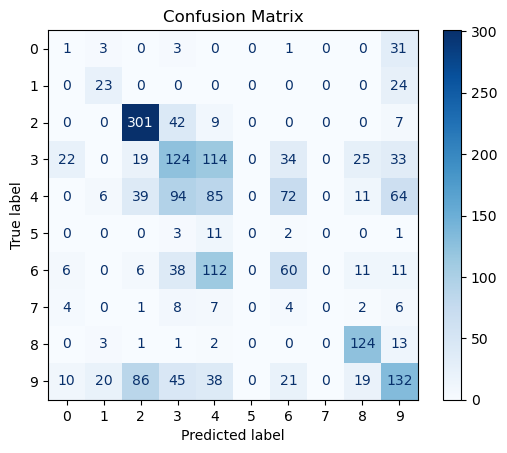

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 读取标签文件
def read_labels(file_path):
    with open(file_path, 'r') as f:
        labels = [int(line.strip()) for line in f]
    return labels

# 主函数
def main(ref_file, pred_file):
    # 读取ref和pred标签
    y_true = read_labels(ref_file)
    y_pred = read_labels(pred_file)

    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(10))
    
    # 绘制混淆矩阵
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# 调用主函数
ref_file = '../data/angular_filtered/subsets/classification/angular_test_references.txt'
pred_file = '../data/angular_filtered/subsets/classification/angular_test_predictions.txt'
main(ref_file, pred_file)

In [6]:
with open('../data/angular_filtered/subsets/classification/test_with_classification.json', 'r', encoding='UTF-8') as f:
    test_data = json.load(f)

for index, item in enumerate(test_data):
    item['seq_num'] = index

with open('../data/angular_filtered/subsets/classification/test_with_classification.json', 'w', encoding='UTF-8') as f:
    json.dump(test_data, f, indent=4)

In [3]:
folder_path = '../data/angular_filtered/subsets/type_db'
files = glob.glob(os.path.join(folder_path, '*db.json'))

test_diff_loader = JSONLoader(
    file_path='../data/angular_filtered/subsets/classification/test_with_classification.json',
    jq_schema='.[].diff',
    text_content=False)

test_diff_data = test_diff_loader.load()
# test_diff_data = test_diff_loader.load()[:1000]

with open('../data/angular_filtered/subsets/classification/test_with_classification.json', 'r', encoding='UTF-8') as f:
    test_data = json.load(f)

In [4]:
grouped_data = defaultdict(list)
for entry in test_data:
    grouped_data[entry['type']].append(entry)
# splitter = RecursiveCharacterTextSplitter.from_language(Language.JS, chunk_size=1000, chunk_overlap=200)
for file in files:
    diff_loader = JSONLoader(
        file_path=file,
        jq_schema='.[].diff',
        text_content=False)
    
    diff_data = diff_loader.load()
    
    msg_loader = JSONLoader(
        file_path=file,
        jq_schema='.[].msg',
        text_content=False)

    msg_data = msg_loader.load()
    # diff_split = []

    # for i, doc in tqdm(enumerate(diff_data), total=len(diff_data), desc="Processing documents"):
    #     diff_split += splitter.split_documents([doc])
    
    type = file.split('\\')[-1].split('_')[1]
    if os.path.exists(f"../data/angular_filtered/subsets/type_db/rag_{type}_db_e5"):
        db = Chroma(persist_directory=f"../data/angular_filtered/subsets/type_db/rag_{type}_db_e5", embedding_function=embeddings)
    else:
        db = Chroma.from_documents(diff_data, embeddings, persist_directory=f"../data/angular_filtered/subsets/type_db/rag_{type}_db_e5")
    # db = Chroma(persist_directory=f"../data/angular_filtered/subsets/type_db/rag_{type}_db_e5", embedding_function=embeddings)
    similar_diff = []
    retriever = db.as_retriever()
    indexs = [item['seq_num'] for item in grouped_data[type]]
    for index in tqdm(indexs, total=len(indexs), desc="Processing documents"):
        similar_diff.append(retriever.invoke(test_diff_data[index].page_content)[0])
    
    for sim_diff, test_diff in zip(similar_diff, grouped_data[type]):
        test_diff['sim_msg'] = msg_data[sim_diff.metadata['seq_num']-1].page_content
        test_diff['sim_diff'] = diff_data[sim_diff.metadata['seq_num']-1].page_content

Processing documents:   0%|          | 0/39 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/371 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/47 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/359 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/371 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/371 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/17 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/244 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/32 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/144 [00:00<?, ?it/s]

In [5]:
values_list = [value for values in grouped_data.values() for value in values]
sorted_items = sorted(values_list, key=lambda x: x['seq_num'])

# Write the data to a JSON file
with open('../data/angular_filtered/subsets/generation/rag/test_golden_classified_rag_prompt.json', 'w', encoding='UTF-8') as f:
    json.dump(sorted_items, f, ensure_ascii=False, indent=4)

In [7]:
from openai import OpenAI

client = OpenAI(
    api_key="sk-0rLvuRkMiD4Mw25QYygh6rUlZVjpQWNGNF4yez7z3PZ7yCOm",
    base_url="https://api.chatanywhere.cn/v1"
)
def gpt_35_api(messages: list):

    completion = client.chat.completions.create(model="gpt-3.5-turbo-0125", messages=messages, temperature=0)
    return completion.choices[0].message.content
import json
from tqdm import tqdm
from langchain import hub
prompt = hub.pull("tyfann/llm4commit-rag")
model = 'golden_classified_rag'
with open(f'../data/angular_filtered/subsets/generation/rag/test_{model}_prompt.json', 'r', encoding='UTF-8') as f:
    org_data = json.load(f)
gpt_msg = []
for index, data in tqdm(enumerate(org_data), total=len(org_data), desc="Processing documents"):
    # merged_diff = '\n'.join(diff['diff'] for diff in data['diff'])
    messages = prompt.invoke(
        {"context": data['sim_diff'], "msg": data['sim_msg'], "type": data['type'], "diff": data['diff']}
    ).to_messages()
    example_prompt = [{'role': 'user','content': messages[0].content},]
    try:
        gpt_msg.append(gpt_35_api(example_prompt))
    except:
        print(index)
        gpt_msg.append('')
    # gpt_msg.append(gpt_35_api(example_prompt))

for item, msg in zip(org_data, gpt_msg):
    item['chatgpt_rag'] = msg

output_file = f'../data/angular_filtered/subsets/generation/test_gpt35_{model}.json'
with open(output_file, 'w', encoding='UTF-8') as f:
    json.dump(org_data, f, ensure_ascii=False, indent=4)
    
output_file = f'../data/angular_filtered/subsets/generation/test_gpt35_{model}.txt'
with open(output_file, 'w', encoding='UTF-8') as f:
    for item in org_data:
        f.write(item['chatgpt_rag'].replace('\n', '\\n').replace('\r', '\\r') + '\n')

Processing documents: 100%|██████████| 1995/1995 [25:08<00:00,  1.32it/s]


## Generalizability Evaluation

In [1]:
from stanfordcorenlp import StanfordCoreNLP
from nltk.tokenize import sent_tokenize
import json
from utils import is_vdo_pattern, is_merge_rollback, tokenize_summary, remove_brackets, replace_issue_id

nlp = StanfordCoreNLP('http://localhost', port=9000)


def commit_processer(msg, nlp):
    ## get the first sentence
    ## remove issue id
    ## remove merge, rollback commits and commits with a diff larger than 1 mb
    ## broke reference messages into tokens
    ## Max length for summary. Default is 30.
    msg = sent_tokenize(msg.strip().replace('\n', '. '))
    if msg is None or msg == []:
        return '', 0
    first_sent = msg[0]
    if is_merge_rollback(first_sent):
        return '', 0
    else:
        first_sent = replace_issue_id(first_sent)
        # first_sent = remove_brackets(first_sent)
        if first_sent is None or first_sent == '':
            return '', 0
        first_sent = tokenize_summary(first_sent)
        if len(first_sent.split()) > 30 or not is_vdo_pattern(first_sent, nlp):
            return '', 0
        else:
            return first_sent, 1


def to_lemma(msg, nlp):
    props = {'annotators': 'lemma', 'outputFormat': 'json', 'timeout': 1000}
    msg_list = msg.split()
    annot_doc = nlp.annotate(msg, properties=props)
    parsed_dict = json.loads(annot_doc)
    lemma_list = [v for d in parsed_dict['sentences'][0]['tokens'] for k, v in d.items() if k == 'lemma']
    msg_list[0] = lemma_list[0]
    msg = ' '.join(msg_list)
    return msg


In [2]:

import pyarrow.parquet as pq
import glob
import os
from tqdm.auto import tqdm

# Create empty dictionaries for each language and type
languages = ['JavaScript']
verb_groups = ['add', 'fix', 'remove', 'update', 'use', 'move', 'prepare', 'improve', 'ignore', 'handle', 'rename',
               'allow', 'set', 'revert', 'replace']

dfs = {lang: {vtype: [] for vtype in verb_groups} for lang in languages}

# Create a tqdm progress bar for each language
bars = {lang: tqdm(total=60000, desc=lang) for lang in languages}  # Total: 10 types * 10000 each

folder_path = '../rag/datasets--JetBrains-Research--commit-chronicle/snapshots/5fd076e67b812a9f3d1999e5e40f71715f84bb51/data'  # 文件夹的路径

files = glob.glob(os.path.join(folder_path, 'train*')) + glob.glob(os.path.join(folder_path, 'validation*'))

for file in files:
    df = pq.read_table(file).to_pandas()

    # Iterate over each language
    for lang in languages[:]:
        # Filter rows where language column matches the current language and additional conditions
        lang_df = df[(df['language'] == lang) &
                     (df['mods'].apply(len) == 1) &
                     (df['message'].apply(lambda x: len(x.split())) <= 30) &
                     (df['mods'].apply(lambda x: x[0]['change_type']) == 'MODIFY') &
                     (df['mods'].apply(lambda x: len(
                         f"diff --git a/{x[0]['old_path']} b/{x[0]['new_path']} {x[0]['diff']}") <= 5000))]
        #  (df['mods'].apply(lambda x: ( (x[0]['old_path'].count(lang_suffix) if x[0]['old_path'] else 0) == 1 and (x[0]['new_path'].count(lang_suffix) if x[0]['new_path'] else 0) == 1 and (x[0]['old_path'].count('.json') if x[0]['old_path'] else 0) == 0 and (x[0]['new_path'].count('.json') if x[0]['new_path'] else 0) == 0 )))]

        # Iterate over each row in the filtered DataFrame
        for index, row in lang_df.iterrows():
            msg = row['message']
            msg = to_lemma(msg, nlp)
            if msg.split()[0] in verb_groups:
                if commit_processer(msg, nlp)[1] == 1:
                    diff = row['mods'][0]
                    old_path = 'a/' + diff['old_path']
                    new_path = 'b/' + diff['new_path']
                    diff_content = diff['diff']  # assume diff_content is an empty string
                    item = {
                        'msg': msg,
                        'diff': f"diff --git {old_path} {new_path} {diff_content}",
                        'date': row['date'],
                        'repo': row['repo']
                    }

                    # Find the type in the message
                    for vtype in verb_groups:
                        if msg.startswith(vtype):
                            if len(dfs[lang][vtype]) < 4000:
                                dfs[lang][vtype].append(item)
                                bars[lang].update(1)
                            break

            if all(len(dfs[lang][vtype]) >= 4000 for vtype in verb_groups):
                print(f"Reached 4000 rows for all types in {lang}")
                languages.remove(lang)  # Remove language from list to avoid further processing
                break

    # Break out of the loop if all languages have reached the required number of rows
    if not languages:
        break

JavaScript:   0%|          | 0/60000 [00:00<?, ?it/s]

In [3]:
for lang in dfs:
    print(f"Language: {lang}")
    for vtype in dfs[lang]:
        print(f"  {vtype}: {len(dfs[lang][vtype])}")

Language: JavaScript
  add: 4000
  fix: 4000
  remove: 4000
  update: 4000
  use: 1570
  move: 463
  prepare: 274
  improve: 3263
  ignore: 587
  handle: 1284
  rename: 1343
  allow: 1704
  set: 1914
  revert: 700
  replace: 1493


In [4]:
data = []

for lang, types in dfs.items():
    for vtype, items in types.items():
        for item in items:
            # item['msg'] = to_lemma(item['msg'], nlp)
            item['type'] = vtype
            data.append(item)

import json

# Dump the data to a JSON file
with open('../data/vdo_filtered/db_data.json', 'w', encoding='UTF-8') as f:
    json.dump(data, f, indent=4)

In [5]:
len(data)

30595

In [6]:
import pyarrow.parquet as pq
import glob
import os
from tqdm.auto import tqdm
# Define the verb groups
verb_groups = ['add', 'fix', 'remove', 'update', 'use', 'move', 'prepare', 'improve', 'ignore', 'handle', 'rename',
               'allow', 'set', 'revert', 'replace']

# Define the counts from your data
counts = {
    'add': 4000,
    'fix': 4000,
    'remove': 4000,
    'update': 4000,
    'use': 1570,
    'move': 463,
    'prepare': 274,
    'improve': 3263,
    'ignore': 587,
    'handle': 1284,
    'rename': 1343,
    'allow': 1704,
    'set': 1914,
    'revert': 700,
    'replace': 1493
}

# Calculate the total count
total_count = sum(counts.values())

# Define the total number of samples you want to collect
total_samples = 2000

# Calculate the target count for each type based on the given counts and total_samples
target_counts = {vtype: int((count / total_count) * total_samples) for vtype, count in counts.items()}

# Create empty dictionaries for each language and type
languages = ['JavaScript']
dfs = {lang: {vtype: [] for vtype in verb_groups} for lang in languages}
counters = {lang: {vtype: 0 for vtype in verb_groups} for lang in languages}

# Create a tqdm progress bar for each language
bars = {lang: tqdm(total=total_samples, desc=lang) for lang in languages}

folder_path = '../rag/datasets--JetBrains-Research--commit-chronicle/snapshots/5fd076e67b812a9f3d1999e5e40f71715f84bb51/data'  # 文件夹的路径

files = glob.glob(os.path.join(folder_path, 'test*'))

for file in files:
    df = pq.read_table(file).to_pandas()

    # Iterate over each language
    for lang in languages[:]:
        # Filter rows where language column matches the current language and additional conditions
        lang_df = df[(df['language'] == lang) &
                     (df['mods'].apply(len) == 1) &
                     (df['message'].apply(lambda x: len(x.split())) <= 30) &
                     (df['mods'].apply(lambda x: x[0]['change_type']) == 'MODIFY') &
                     (df['mods'].apply(lambda x: len(
                         f"diff --git a/{x[0]['old_path']} b/{x[0]['new_path']} {x[0]['diff']}") <= 5000))]

        # Iterate over each row in the filtered DataFrame
        for index, row in lang_df.iterrows():
            msg = row['message']
            msg = to_lemma(msg, nlp)
            if msg.split()[0] in verb_groups:
                if commit_processer(msg, nlp)[1] == 1:
                    diff = row['mods'][0]
                    old_path = 'a/' + diff['old_path']
                    new_path = 'b/' + diff['new_path']
                    diff_content = diff['diff']
                    item = {
                        'msg': msg,
                        'diff': f"diff --git {old_path} {new_path} {diff_content}",
                        'date': row['date'],
                        'repo': row['repo']
                    }

                    # Find the type in the message
                    for vtype in verb_groups:
                        if msg.startswith(vtype):
                            if counters[lang][vtype] < target_counts[vtype]:
                                dfs[lang][vtype].append(item)
                                counters[lang][vtype] += 1
                                bars[lang].update(1)
                            break

            if all(counters[lang][vtype] >= target_counts[vtype] for vtype in verb_groups):
                print(f"Reached target counts for all types in {lang}")
                languages.remove(lang)
                break

    if not languages:
        break

# Print the number of items collected for each type
for lang in dfs:
    for vtype in dfs[lang]:
        print(f"Type: {vtype}, Count: {len(dfs[lang][vtype])}")

JavaScript:   0%|          | 0/2000 [00:00<?, ?it/s]

Reached target counts for all types in JavaScript
Type: add, Count: 261
Type: fix, Count: 261
Type: remove, Count: 261
Type: update, Count: 261
Type: use, Count: 102
Type: move, Count: 30
Type: prepare, Count: 17
Type: improve, Count: 213
Type: ignore, Count: 38
Type: handle, Count: 83
Type: rename, Count: 87
Type: allow, Count: 111
Type: set, Count: 125
Type: revert, Count: 45
Type: replace, Count: 97


In [7]:
test_data = []

for lang, types in dfs.items():
    for atype, items in types.items():
        if items:  # Ensure there are items to split
            for item in items:
                item['type'] = atype
            test_data.extend(items)

import json
output_dir = '../data/vdo_filtered'
with open(os.path.join(output_dir, f'test_data.json'), 'w') as db_file:
    json.dump(test_data, db_file, indent=4)

In [8]:
len(test_data)

1992

### Model generation

RACE

In [9]:
import json
from tqdm.auto import tqdm
with open('../data/vdo_filtered/test_data.json') as f:
    prompt_data = json.load(f)
    
import os
os.environ['HF_HOME'] = '../models/'

from transformers import pipeline
pipe = pipeline("text2text-generation", model="JetBrains-Research/cmg-race-without-history", device=0)

In [10]:

diffs = []
generated_commit_messages = []

for commit in prompt_data:
    diff = commit['diff']
    diffs.append(diff)

for diff in tqdm(diffs, total=len(diffs), desc='Generating commit messages'):
    prompt = f"""
    The following is a diff which describes the code changes in a commit, Your task is to write a short commit message accordingly.
    {diff}
    According to the diff, the commit message should be:
    """
    generated_commit_messages.append(pipe(diff)[0]['generated_text'])


for item, msg in zip(prompt_data, generated_commit_messages):
    item['race'] = msg

output_file = '../data/vdo_filtered/generation/test_race.json'
with open(output_file, 'w', encoding='UTF-8') as f:
    json.dump(prompt_data, f, ensure_ascii=False, indent=4)

# save msg to a file
with open("../data/vdo_filtered/generation/test_race.txt", 'w', encoding='UTF-8') as file:
    for item in prompt_data:
        file.write(item['race'].replace('\n', '\\n').replace('\r', '\\r') + '\n')

Generating commit messages:   0%|          | 0/1992 [00:00<?, ?it/s]

C:\Users\tyfann\anaconda3\envs\llm4commit\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\tyfann\anaconda3\envs\llm4commit\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "C:\Users\tyfann\anaconda3\envs\llm4commit\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "C:\Users\tyfann\anaconda3\envs\llm4commit\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "C:\Users\tyfann\anaconda3\envs\llm4commit\lib\logging\__init__.

chatgpt

In [11]:
from langchain import hub
import json
from tqdm import tqdm
prompt = hub.pull("tyfann/llm4commit-zeroshot")

from openai import OpenAI

client = OpenAI(
    api_key="sk-0rLvuRkMiD4Mw25QYygh6rUlZVjpQWNGNF4yez7z3PZ7yCOm",
    base_url="https://api.chatanywhere.cn/v1"
)

def gpt_35_api(messages: list):

    completion = client.chat.completions.create(model="gpt-3.5-turbo-0125", messages=messages, temperature=0)
    return completion.choices[0].message.content

with open('../data/vdo_filtered/test_data.json', 'r', encoding='UTF-8') as f:
    org_data = json.load(f)

gpt_msg = []
for index, data in tqdm(enumerate(org_data), total=len(org_data), desc="Processing documents"):
    # merged_diff = '\n'.join(diff['diff'] for diff in data['diff'])
    messages = prompt.invoke(
        {"DIFF": data['diff']}
    ).to_messages()
    example_prompt = [{'role': 'user','content': messages[0].content},]
    try:
        gpt_msg.append(gpt_35_api(example_prompt))
    except:
        print(index)
        gpt_msg.append("")

for item, msg in zip(org_data, gpt_msg):
    item['chatgpt_zeroshot'] = msg
import os
# output_file = '../data/chronicle/rag_baseline/zeroshot/rag_baseline_python_chatgpt.json'
output_file = '../data/vdo_filtered/generation/test_gpt35_zeroshot.json'
os.makedirs(os.path.dirname(output_file), exist_ok=True)
with open(output_file, 'w', encoding='UTF-8') as f:
    json.dump(org_data, f, ensure_ascii=False, indent=4)

output_file = '../data/vdo_filtered/generation/test_gpt35_zeroshot.txt'
with open(output_file, 'w', encoding='UTF-8') as f:
    for item in org_data:
        f.write(item['chatgpt_zeroshot'].replace('\n', '\\n').replace('\r', '\\r') + '\n')

Processing documents: 100%|██████████| 1992/1992 [24:15<00:00,  1.37it/s]


In [12]:
output_file = '../data/vdo_filtered/generation/test_ref.txt'
with open(output_file, 'w', encoding='UTF-8') as f:
    for item in org_data:
        f.write(item['msg'].replace('\n', '\\n').replace('\r', '\\r') + '\n')

vanilla RAG

In [2]:
diff_loader = JSONLoader(
    file_path='../data/vdo_filtered/db_data.json',
    jq_schema='.[].diff',
    text_content=False)

diff_data = diff_loader.load()

msg_loader = JSONLoader(
    file_path='../data/vdo_filtered/db_data.json',
    jq_schema='.[].msg',
    text_content=False)

msg_data = msg_loader.load()

In [3]:
test_diff_loader = JSONLoader(
    file_path='../data/vdo_filtered/test_data.json',
    jq_schema='.[].diff',
    text_content=False)

test_diff_data = test_diff_loader.load()
# test_diff_data = test_diff_loader.load()[:1000]

with open('../data/vdo_filtered/test_data.json', 'r', encoding='UTF-8') as f:
    test_data = json.load(f)

In [4]:
if os.path.exists(f"../data/vdo_filtered/type_db/rag_all_types_db_e5_nochunk"):
    db = Chroma(persist_directory=f"../data/vdo_filtered/type_db/rag_all_types_db_e5_nochunk", embedding_function=embeddings)
else:
    db = Chroma.from_documents(diff_data, embeddings, persist_directory="../data/vdo_filtered/type_db/rag_all_types_db_e5_nochunk")

NameError: name 'embeddings' is not defined

In [12]:
similar_diff = []
retriever = db.as_retriever()
for diff_doc in tqdm(test_diff_data, total=len(test_diff_data), desc="Processing documents"):
    similar_diff.append(retriever.invoke(diff_doc.page_content)[0])

for sim_diff, test_item in zip(similar_diff, test_data):
    test_item['sim_msg'] = msg_data[sim_diff.metadata['seq_num'] - 1].page_content
    test_item['sim_diff'] = diff_data[sim_diff.metadata['seq_num'] - 1].page_content

with open('../data/vdo_filtered/generation/rag/test_rag_prompt.json', 'w',
          encoding='UTF-8') as f:
    json.dump(test_data, f, ensure_ascii=False, indent=4)

Processing documents:   0%|          | 0/1992 [00:00<?, ?it/s]

In [5]:

from openai import OpenAI

client = OpenAI(
    api_key="sk-0rLvuRkMiD4Mw25QYygh6rUlZVjpQWNGNF4yez7z3PZ7yCOm",
    base_url="https://api.chatanywhere.cn/v1"
)


def gpt_35_api(messages: list):
    completion = client.chat.completions.create(model="gpt-3.5-turbo-0125", messages=messages, temperature=0)
    return completion.choices[0].message.content


import json
from tqdm import tqdm
from langchain import hub

prompt = hub.pull("tyfann/llm4commit-rag:b843ef0b")

with open(f'../data/vdo_filtered/generation/rag/test_rag_prompt.json', 'r',
          encoding='UTF-8') as f:
    org_data = json.load(f)
gpt_msg = []
for index, data in tqdm(enumerate(org_data), total=len(org_data), desc="Processing documents"):
    messages = prompt.invoke(
        {"context": data['sim_diff'], "msg": data['sim_msg'], "diff": data['diff']}
    ).to_messages()
    example_prompt = [{'role': 'user', 'content': messages[0].content}, ]
    try:
        gpt_msg.append(gpt_35_api(example_prompt))
    except:
        print(index)
        gpt_msg.append('')

for item, msg in zip(org_data, gpt_msg):
    item['chatgpt_rag'] = msg

output_file = f'../data/vdo_filtered/generation/rag/test_gpt35_rag.json'
with open(output_file, 'w', encoding='UTF-8') as f:
    json.dump(org_data, f, ensure_ascii=False, indent=4)

output_file = f'../data/vdo_filtered/generation/rag/test_gpt35_rag.txt'
with open(output_file, 'w', encoding='UTF-8') as f:
    for item in org_data:
        f.write(item['chatgpt_rag'].replace('\n', '\\n').replace('\r', '\\r') + '\n')

Processing documents: 100%|██████████| 1992/1992 [26:49<00:00,  1.24it/s]  


classification model

In [3]:
import json
import os

# 假设json文件名为data.json
input_filename = '../data/vdo_filtered/db_data.json'
output_dir = '../data/vdo_filtered/type_db'

# 创建输出目录
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 读取JSON文件
with open(input_filename, 'r', encoding='utf-8') as file:
    data = json.load(file)

# 初始化一个字典用于存储每种type的数据
type_dict = {}

# 遍历每一个item，根据type分类
for item in data:
    item_type = item['type']
    if item_type not in type_dict:
        type_dict[item_type] = []
    type_dict[item_type].append(item)

# 将分类好的数据写入不同的文件
for item_type, items in type_dict.items():
    output_filename = os.path.join(output_dir, f'JavaScript_{item_type}_db.json')
    with open(output_filename, 'w', encoding='utf-8') as file:
        json.dump(items, file, ensure_ascii=False, indent=4)

In [2]:
import os
# Define the directory containing the JSON files
output_dir = '../data/vdo_filtered/classification'

# List of types and their corresponding labels
types = [
    'add', 'fix', 'remove', 'update', 'use', 
    'move', 'prepare', 'improve', 'ignore', 'handle',
    'rename', 'allow', 'set', 'revert', 'replace'
]
type_label_mapping = {type_name: idx for idx, type_name in enumerate(types)}

# Save the type-label mapping to a txt file
with open(os.path.join(output_dir, 'type_label_mapping.txt'), 'w') as mapping_file:
    for type_name, label in type_label_mapping.items():
        mapping_file.write(f'{type_name}: {label}\n')

In [4]:
import json
import glob
import os
from sklearn.model_selection import train_test_split
import random
random.seed(42)

# Define the directory containing the JSON files
output_dir = '../../CodeBERT-classification/dataset'

# List of types and their corresponding labels
types = [
    'add', 'fix', 'remove', 'update', 'use', 
    'move', 'prepare', 'improve', 'ignore', 'handle',
    'rename', 'allow', 'set', 'revert', 'replace'
]
type_label_mapping = {type_name: idx for idx, type_name in enumerate(types)}

train_items = []
valid_items = []

# Read and process all test JSON files
for type_name in types:
    test_file = os.path.join('../data/vdo_filtered/type_db', f'JavaScript_{type_name}_db.json')
    if os.path.exists(test_file):
        with open(test_file, 'r') as f:
            items = json.load(f)
            data = [
                {
                    "code": item['diff'],
                    "label": type_label_mapping[type_name]
                }
                for item in items
            ]
            # Split data into 1:8 ratio
            train_split, valid_split = train_test_split(data, test_size=1/10, random_state=42)
            valid_items.extend(valid_split)
            train_items.extend(train_split)

# Shuffle the items to randomize their order
random.shuffle(valid_items)
random.shuffle(train_items)

# Save validation items to valid.jsonl
with open(os.path.join(output_dir, 'valid_vdo.jsonl'), 'w') as valid_file:
    for item in valid_items:
        valid_file.write(json.dumps(item) + '\n')

# Save training items to train.jsonl
with open(os.path.join(output_dir, 'train_vdo.jsonl'), 'w') as train_file:
    for item in train_items:
        train_file.write(json.dumps(item) + '\n')

print("Data splitting and saving to JSONL files completed.")


Data splitting and saving to JSONL files completed.


In [5]:
def read_mapping(file_path):
    mapping = {}
    with open(file_path, 'r') as f:
        for line in f:
            key, value = line.strip().split(': ')
            mapping[key] = int(value)
    return mapping

# 读取json文件
def read_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# 写入jsonl文件
def write_jsonl(file_path, data):
    with open(file_path, 'w') as f:
        for item in data:
            json.dump(item, f)
            f.write('\n')

# 主函数
def main(mapping_file, json_file, output_file):
    # 读取mapping和json数据
    mapping = read_mapping(mapping_file)
    json_data = read_json(json_file)
    # random.seed(42)
    # random.shuffle(json_data)

    # 生成新的jsonl数据
    new_data = []
    for item in json_data:
        new_item = {
            "code": item["diff"],
            "label": mapping[item["type"]]
        }
        new_data.append(new_item)

    # 写入新的jsonl文件
    write_jsonl(output_file, new_data)

# 调用主函数
mapping_file = '../data/vdo_filtered/classification/type_label_mapping.txt'
json_file = '../data/vdo_filtered/test_data.json'
output_file = '../../CodeBERT-classification/dataset/test_vdo.jsonl'
main(mapping_file, json_file, output_file)

In [32]:
import json
with open('../data/vdo_filtered/generation/rag/test_rag_prompt.json', 'r', encoding='UTF-8') as f:
    prompt = json.load(f)

In [5]:
count = 0
for item in prompt:
    if item['sim_msg'].split()[0] == item['type']:
        count += 1

print(count / len(prompt) * 100)

14.156626506024098


In [34]:
# 读取mapping.txt文件
def read_mapping(file_path):
    mapping = {}
    with open(file_path, 'r', encoding='UTF-8') as f:
        for line in f:
            key, value = line.strip().split(': ')
            mapping[key] = int(value)  # 将value转换为int作为键，key作为值
    return mapping
mapping_file = '../data/vdo_filtered/classification/type_label_mapping.txt'
mapping = read_mapping(mapping_file)

pred_vdo_type_mapping = []
for item in prompt:
    pred_vdo_type_mapping.append(mapping[item['sim_msg'].split()[0]])
# to a txt file
with open('../data/vdo_filtered/classification/vdo_test_rag_predictions.txt', 'w', encoding='UTF-8') as file:
    for item in pred_vdo_type_mapping:
        file.write(f'{item}\n')

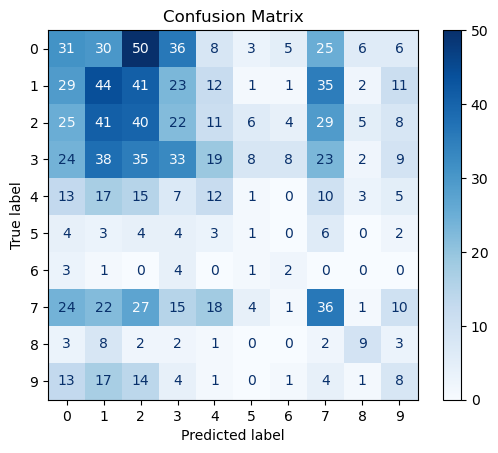

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 读取标签文件
def read_labels(file_path):
    with open(file_path, 'r') as f:
        labels = [int(line.strip()) for line in f]
    return labels

# 主函数
def main(ref_file, pred_file):
    # 读取ref和pred标签
    y_true = read_labels(ref_file)
    y_pred = read_labels(pred_file)

    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(15))
    
    # 绘制混淆矩阵
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(15))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# 调用主函数
ref_file = '../data/vdo_filtered/classification/vdo_test_references.txt'
pred_file = '../data/vdo_filtered/classification/vdo_test_rag_predictions.txt'
main(ref_file, pred_file)

In [35]:
import json

# 读取mapping.txt文件
def read_mapping(file_path):
    mapping = {}
    with open(file_path, 'r', encoding='UTF-8') as f:
        for line in f:
            key, value = line.strip().split(': ')
            mapping[int(value)] = key  # 将value转换为int作为键，key作为值
    return mapping

# 读取json文件
def read_json(file_path):
    with open(file_path, 'r', encoding='UTF-8') as f:
        data = json.load(f)
    return data

# 读取pred.txt文件
def read_labels(file_path):
    with open(file_path, 'r', encoding='UTF-8') as f:
        labels = [int(line.strip()) for line in f]
    return labels

# 写入json文件
def write_json(file_path, data):
    with open(file_path, 'w', encoding='UTF-8') as f:
        json.dump(data, f, indent=4)

# 主函数
def main(mapping_file, json_file, pred_file, output_file):
    # 读取mapping和json数据
    mapping = read_mapping(mapping_file)
    json_data = read_json(json_file)
    pred_labels = read_labels(pred_file)

    # 添加classifier_type字段
    for item, label in zip(json_data, pred_labels):
        item["classifier_type"] = mapping[label]

    # 写入更新后的json文件
    write_json(output_file, json_data)

# 调用主函数
mapping_file = '../data/vdo_filtered/classification/type_label_mapping.txt'
json_file = '../data/vdo_filtered/test_data.json'
pred_file = '../data/vdo_filtered/classification/vdo_test_predictions.txt'
output_file = '../data/vdo_filtered/classification/test_with_classification.json'
main(mapping_file, json_file, pred_file, output_file)

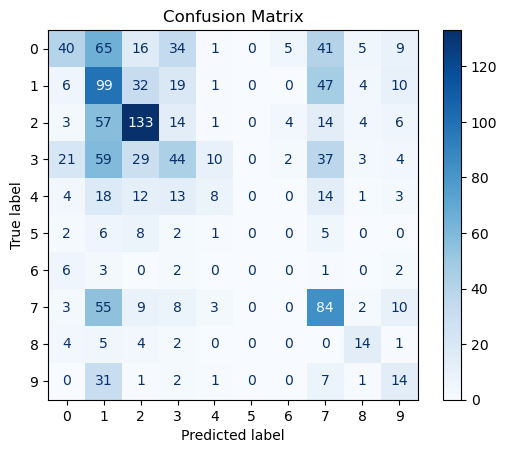

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 读取标签文件
def read_labels(file_path):
    with open(file_path, 'r') as f:
        labels = [int(line.strip()) for line in f]
    return labels

# 主函数
def main(ref_file, pred_file):
    # 读取ref和pred标签
    y_true = read_labels(ref_file)
    y_pred = read_labels(pred_file)

    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(15))
    
    # 绘制混淆矩阵
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(15))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# 调用主函数
ref_file = '../data/vdo_filtered/classification/vdo_test_references.txt'
pred_file = '../data/vdo_filtered/classification/vdo_test_predictions.txt'
main(ref_file, pred_file)

In [4]:
import glob, os
with open('../data/vdo_filtered/classification/test_with_classification.json', 'r', encoding='UTF-8') as f:
    test_data = json.load(f)

for index, item in enumerate(test_data):
    item['seq_num'] = index

with open('../data/vdo_filtered/classification/test_with_classification.json', 'w', encoding='UTF-8') as f:
    json.dump(test_data, f, indent=4)

folder_path = '../data/vdo_filtered/type_db'
files = glob.glob(os.path.join(folder_path, '*db.json'))

In [5]:

test_diff_loader = JSONLoader(
    file_path='../data/vdo_filtered/classification/test_with_classification.json',
    jq_schema='.[].diff',
    text_content=False)

test_diff_data = test_diff_loader.load()
# test_diff_data = test_diff_loader.load()[:1000]

with open('../data/vdo_filtered/classification/test_with_classification.json', 'r', encoding='UTF-8') as f:
    test_data = json.load(f)

In [6]:
grouped_data = defaultdict(list)
for entry in test_data:
    grouped_data[entry['type']].append(entry)
# splitter = RecursiveCharacterTextSplitter.from_language(Language.JS, chunk_size=1000, chunk_overlap=200)
for file in files:
    diff_loader = JSONLoader(
        file_path=file,
        jq_schema='.[].diff',
        text_content=False)

    diff_data = diff_loader.load()

    msg_loader = JSONLoader(
        file_path=file,
        jq_schema='.[].msg',
        text_content=False)

    msg_data = msg_loader.load()
    # diff_split = []

    # for i, doc in tqdm(enumerate(diff_data), total=len(diff_data), desc="Processing documents"):
    #     diff_split += splitter.split_documents([doc])

    type = file.split('\\')[-1].split('_')[1]
    if os.path.exists(f"../data/vdo_filtered/type_db/rag_{type}_db_e5"):
        db = Chroma(persist_directory=f"../data/vdo_filtered/type_db/rag_{type}_db_e5",
                    embedding_function=embeddings)
    else:
        db = Chroma.from_documents(diff_data, embeddings,
                                   persist_directory=f"../data/vdo_filtered/type_db/rag_{type}_db_e5")
    # db = Chroma(persist_directory=f"../data/angular_filtered/subsets/type_db/rag_{type}_db_e5", embedding_function=embeddings)
    similar_diff = []
    retriever = db.as_retriever()
    indexs = [item['seq_num'] for item in grouped_data[type]]
    for index in tqdm(indexs, total=len(indexs), desc="Processing documents"):
        similar_diff.append(retriever.invoke(test_diff_data[index].page_content)[0])

    for sim_diff, test_diff in zip(similar_diff, grouped_data[type]):
        test_diff['sim_msg'] = msg_data[sim_diff.metadata['seq_num'] - 1].page_content
        test_diff['sim_diff'] = diff_data[sim_diff.metadata['seq_num'] - 1].page_content

Processing documents:   0%|          | 0/261 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/111 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/261 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/83 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/38 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/213 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/30 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/17 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/261 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/87 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/97 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/45 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/125 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/261 [00:00<?, ?it/s]

Processing documents:   0%|          | 0/102 [00:00<?, ?it/s]

In [7]:
values_list = [value for values in grouped_data.values() for value in values]
sorted_items = sorted(values_list, key=lambda x: x['seq_num'])

# Write the data to a JSON file
with open('../data/vdo_filtered/generation/rag/test_golden_classified_rag_prompt.json', 'w',
          encoding='UTF-8') as f:
    json.dump(sorted_items, f, ensure_ascii=False, indent=4)

In [9]:
from openai import OpenAI
client = OpenAI(
    api_key="sk-0rLvuRkMiD4Mw25QYygh6rUlZVjpQWNGNF4yez7z3PZ7yCOm",
    base_url="https://api.chatanywhere.cn/v1"
)


def gpt_35_api(messages: list):
    completion = client.chat.completions.create(model="gpt-3.5-turbo-0125", messages=messages, temperature=0)
    return completion.choices[0].message.content


import json
from tqdm import tqdm
from langchain import hub

prompt = hub.pull("tyfann/llm4commit-rag")
model = 'golden_classified_rag'
with open(f'../data/vdo_filtered/generation/rag/test_{model}_prompt.json', 'r', encoding='UTF-8') as f:
    org_data = json.load(f)
gpt_msg = []
for index, data in tqdm(enumerate(org_data), total=len(org_data), desc="Processing documents"):
    # merged_diff = '\n'.join(diff['diff'] for diff in data['diff'])
    messages = prompt.invoke(
        {"context": data['sim_diff'], "msg": data['sim_msg'], "type": data['type'], "diff": data['diff']}
    ).to_messages()
    example_prompt = [{'role': 'user', 'content': messages[0].content}, ]
    try:
        gpt_msg.append(gpt_35_api(example_prompt))
    except:
        print(index)
        gpt_msg.append('')
    # gpt_msg.append(gpt_35_api(example_prompt))

for item, msg in zip(org_data, gpt_msg):
    item['chatgpt_rag'] = msg

output_file = f'../data/vdo_filtered/generation/test_gpt35_{model}.json'
with open(output_file, 'w', encoding='UTF-8') as f:
    json.dump(org_data, f, ensure_ascii=False, indent=4)

output_file = f'../data/vdo_filtered/generation/test_gpt35_{model}.txt'
with open(output_file, 'w', encoding='UTF-8') as f:
    for item in org_data:
        f.write(item['chatgpt_rag'].replace('\n', '\\n').replace('\r', '\\r') + '\n')

Processing documents: 100%|██████████| 1992/1992 [23:14<00:00,  1.43it/s]


NNGen

In [18]:
import re

def convert_diff(diff_output):
    # Replace diff --git a/ with mmm a/
    diff_output = re.sub(r'diff --git a/(.*) b/(.*)', r'mmm a/\1\nppp b/\1', diff_output)
    # Replace newline characters with <nl>
    diff_output = diff_output.replace('\n', '<nl>')
    # Split the output into individual words and join them back together with spaces
    words = re.split(r'(\W)', diff_output)
    result = ' '.join(words)
    # Replace multiple spaces with a single space
    result = re.sub(r'\s+', ' ', result)
    result = result.replace('< nl >', '<nl>')
    return result

In [19]:
import json
with open(f'../data/vdo_filtered/db_data.json') as f:
    db_data = json.load(f)

for item in db_data:
    item['diff'] = convert_diff(item['diff'])

# save diff to .diff file
with open('../data/vdo_filtered/generation/nngen/train.diff', 'w') as f:
    for item in db_data:
        f.write(item['diff'] + '\n')

with open('../data/vdo_filtered/generation/nngen/train.msg', 'w') as f:
    for item in db_data:
        escaped_string = item['msg'].replace("\n", "\\n").replace("\r", "\\r")
        f.write(escaped_string + "\n")

with open(f'../data/vdo_filtered/test_data.json') as f:
    test_data = json.load(f)

for item in test_data:
    item['diff'] = convert_diff(item['diff'])

# save diff to .diff file
with open('../data/vdo_filtered/generation/nngen/test.diff', 'w') as f:
    for item in test_data:
        f.write(item['diff'] + '\n')

In [20]:
import json
with open('../data/vdo_filtered/test_data.json', 'r', encoding='UTF-8') as f:
    org_data = json.load(f)

output_file = '../data/vdo_filtered/generation/test_nngen.txt'
with open(output_file, 'r', encoding='UTF-8') as f:
    lines = f.readlines()
    for i in range(len(org_data)):
        org_data[i]['nngen'] = lines[i].strip()

with open('../data/vdo_filtered/generation/test_nngen.json', 'w', encoding='UTF-8') as f:
    json.dump(org_data, f, indent=4)